# Representation learning for bone fractures


In [ ]:
import os
import pandas as pd
from pathlib import Path
from PIL import Image
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm

# Data preprocessing

In [2]:
# Define the size to resize images to
size = (224, 224)

# Define the path to the data directory
train_dir = Path('train')
test_dir = Path('valid')

In [3]:
class ImageDataset(Dataset):
    """Custom Dataset for loading and preprocessing images on-the-fly"""
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['file_path']
        label = row['label']
        # Load and preprocess the image
        with Image.open(image_path) as img:
            img_gray = img.convert('L')
            if self.transform:
                img_gray = self.transform(img_gray)
        return img_gray, label

In [4]:
def load_data(data_dir):
    # Initialize lists to hold file paths, labels, and body parts
    file_paths = []
    labels = []
    body_parts = []

    # Loop over all the body parts directories in the data directory
    for body_part_dir in data_dir.iterdir():
        body_part = body_part_dir.name.split('_')[-1]

        # Loop over all the patient directories in each body part directory
        for patient_dir in body_part_dir.iterdir():

            # Loop over all the study directories in each patient directory
            for study_dir in patient_dir.iterdir():

                # Get the label from the study directory name ('positive' or 'negative')
                label = str(study_dir).split('_')[-1]

                # Loop over all the images in each study directory
                for image_path in study_dir.glob('*.png'):

                    # Append the data to the lists
                    file_paths.append(image_path)
                    labels.append(label)
                    body_parts.append(body_part)

    # Create a DataFrame from the lists
    df = pd.DataFrame({
        'file_path': file_paths,
        'label': labels,
        'body_part': body_parts,
    })

    # Map the labels to integers
    label_mapping = {'positive': 1, 'negative': 0}
    df['label'] = df['label'].map(label_mapping)

    return df

In [5]:
from sklearn.model_selection import train_test_split

# Load training and validation data
train_df = load_data(train_dir)
test_df = load_data(test_dir)

# Split the train dataset into train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Define data transformations
train_transforms = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_transforms = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transforms = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
# Create ImageDataset objects for the training set, validation set, and test set
train_dataset = ImageDataset(train_df, transform=train_transforms)
val_dataset = ImageDataset(val_df, transform=val_transforms)
test_dataset = ImageDataset(test_df, transform=test_transforms)

# Create DataLoaders for the training set, validation set, and test set
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# EDA

Training data shape: (15082, 3)
Validation data shape: (3771, 3)
Test data shape: (1488, 3)

Training data:
label
0    8931
1    6151
Name: count, dtype: int64
body_part
SHOULDER    6752
HAND        4377
ELBOW       3953
Name: count, dtype: int64

Validation data:
label
0    2264
1    1507
Name: count, dtype: int64
body_part
SHOULDER    1627
HAND        1166
ELBOW        978
Name: count, dtype: int64

Test data:
label
0    791
1    697
Name: count, dtype: int64
body_part
SHOULDER    563
ELBOW       465
HAND        460
Name: count, dtype: int64


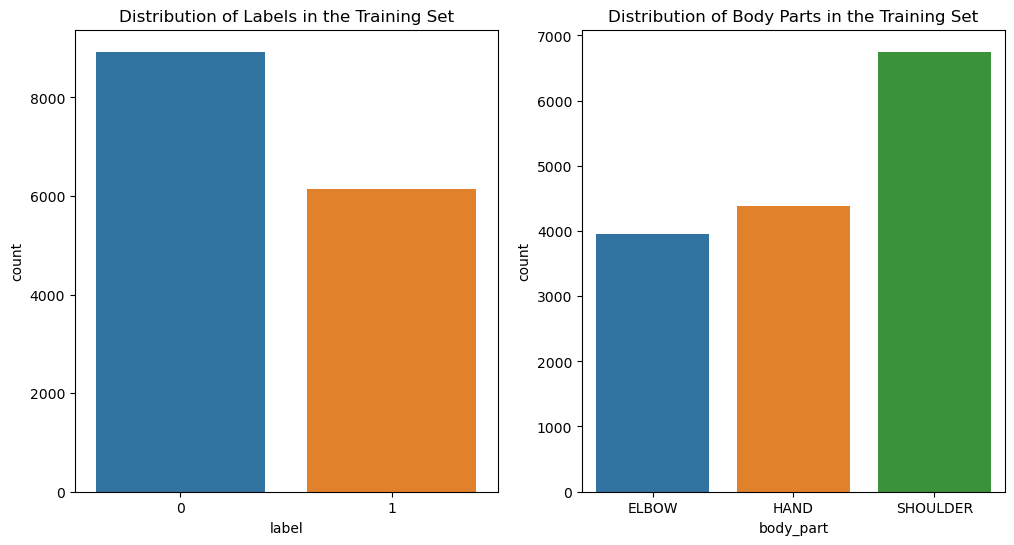

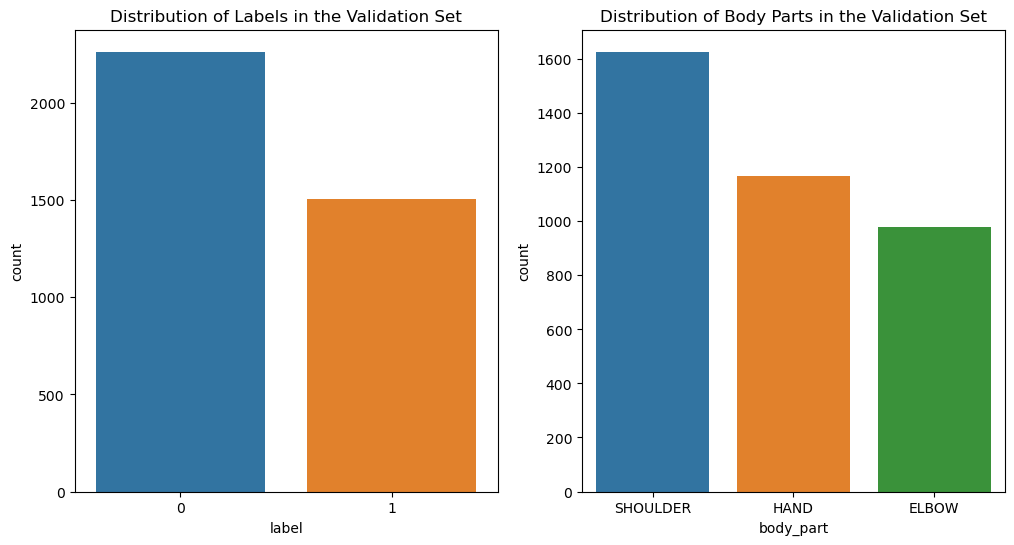

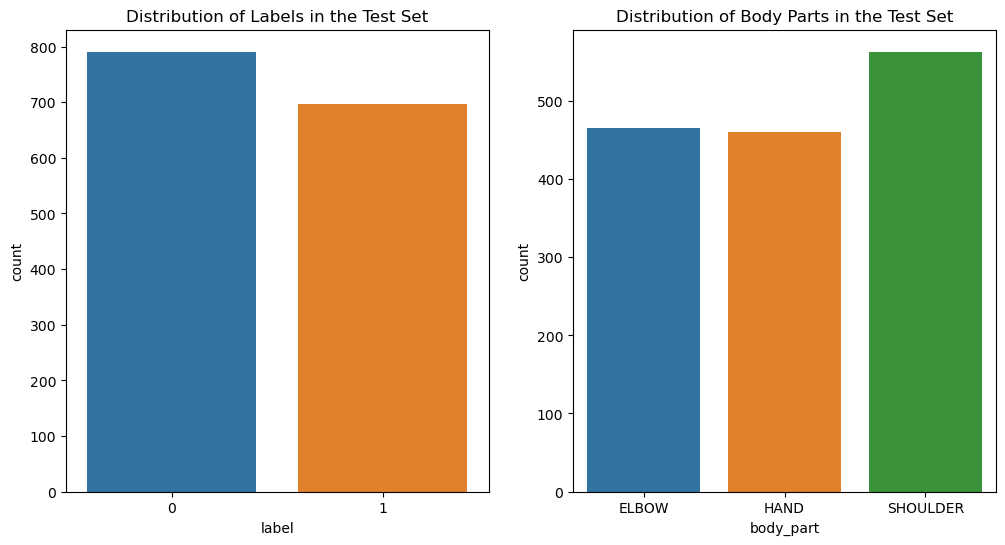

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
# Print the shape of the training and validation dataframes
print(f"Training data shape: {train_df.shape}")
print(f"Validation data shape: {val_df.shape}")
print(f"Test data shape: {test_df.shape}")

# Print the distribution of labels and body parts in the training set
print("\nTraining data:")
print(train_df['label'].value_counts())
print(train_df['body_part'].value_counts())

# Print the distribution of labels and body parts in the validation set
print("\nValidation data:")
print(val_df['label'].value_counts())
print(val_df['body_part'].value_counts())

# Print the distribution of labels and body parts in the test set
print("\nTest data:")
print(test_df['label'].value_counts())
print(test_df['body_part'].value_counts())


# Plot the distribution of labels and body parts in the training set
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=train_df, x='label')
plt.title("Distribution of Labels in the Training Set")
plt.subplot(1, 2, 2)
sns.countplot(data=train_df, x='body_part')
plt.title("Distribution of Body Parts in the Training Set")
plt.show()

# Plot the distribution of labels and body parts in the validation set
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=val_df, x='label')
plt.title("Distribution of Labels in the Validation Set")
plt.subplot(1, 2, 2)
sns.countplot(data=val_df, x='body_part')
plt.title("Distribution of Body Parts in the Validation Set")
plt.show()

# Plot the distribution of labels and body parts in the test set
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=test_df, x='label')
plt.title("Distribution of Labels in the Test Set")
plt.subplot(1, 2, 2)
sns.countplot(data=test_df, x='body_part')
plt.title("Distribution of Body Parts in the Test Set")
plt.show()




# Base Model

In [8]:
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [9]:
base_model = SimpleCNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
base_model.to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(base_model.parameters(), lr=0.001)

cuda:0


In [10]:
from tqdm import tqdm

# Train the model
n_epochs = 5
train_loss_history = []
valid_loss_history = []
train_acc_history = []
valid_acc_history = []

for epoch in tqdm(range(n_epochs)):
    base_model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = base_model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        predicted = (outputs.squeeze() > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = train_loss / len(train_dataloader.dataset)
    train_accuracy = correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_accuracy)

    base_model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = base_model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            valid_loss += loss.item() * inputs.size(0)
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    valid_loss = valid_loss / len(val_dataloader.dataset)
    valid_accuracy = correct / total
    valid_loss_history.append(valid_loss)
    valid_acc_history.append(valid_accuracy)

    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}')

# Save the model
torch.save(base_model.state_dict(), 'base_model.pth')
# save the training history
torch.save({
    'train_loss_history': train_loss_history,
    'valid_loss_history': valid_loss_history,
    'train_acc_history': train_acc_history,
    'valid_acc_history': valid_acc_history
}, 'base_model_history.pth')


 20%|██        | 1/5 [01:20<05:22, 80.56s/it]

Epoch 1/5, Train Loss: 1.2583, Train Accuracy: 0.5848, Validation Loss: 0.6544, Validation Accuracy: 0.6083


 40%|████      | 2/5 [02:36<03:52, 77.55s/it]

Epoch 2/5, Train Loss: 0.6575, Train Accuracy: 0.6035, Validation Loss: 0.6459, Validation Accuracy: 0.6250


 60%|██████    | 3/5 [03:51<02:33, 76.63s/it]

Epoch 3/5, Train Loss: 0.6479, Train Accuracy: 0.6219, Validation Loss: 0.6367, Validation Accuracy: 0.6441


 80%|████████  | 4/5 [05:07<01:16, 76.47s/it]

Epoch 4/5, Train Loss: 0.6314, Train Accuracy: 0.6483, Validation Loss: 0.6347, Validation Accuracy: 0.6457


100%|██████████| 5/5 [06:25<00:00, 77.11s/it]

Epoch 5/5, Train Loss: 0.6092, Train Accuracy: 0.6661, Validation Loss: 0.6287, Validation Accuracy: 0.6526


In [11]:
# load the model
base_model.load_state_dict(torch.load('base_model.pth'))
# load the training history
checkpoint = torch.load('base_model_history.pth')
train_loss_history = checkpoint['train_loss_history']
valid_loss_history = checkpoint['valid_loss_history']
train_acc_history = checkpoint['train_acc_history']
valid_acc_history = checkpoint['valid_acc_history']

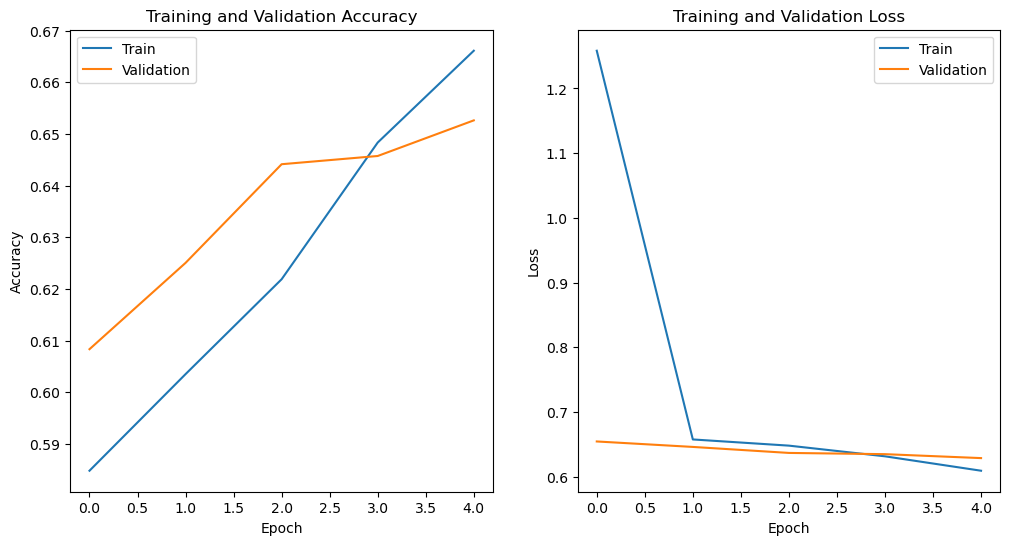

In [12]:
import matplotlib.pyplot as plt

# plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Train')
plt.plot(valid_acc_history, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")

# plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Train')
plt.plot(valid_loss_history, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss")

plt.show()


# part 2 - BYOL model

In [13]:
# Define new data transformations for the new views
train_new_view_transforms = transforms.Compose([
    transforms.Resize(size),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_new_view_transforms = transforms.Compose([
    transforms.Resize(size),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create new ImageDataset objects for the new views
train_new_view_dataset = ImageDataset(train_df, transform=train_new_view_transforms)
val_new_view_dataset = ImageDataset(val_df, transform=val_new_view_transforms)

# Create new DataLoaders for the new views
train_new_view_dataloader = DataLoader(train_new_view_dataset, batch_size=128, shuffle=True)
val_new_view_dataloader = DataLoader(val_new_view_dataset, batch_size=128, shuffle=False)



In [14]:
import torch
from torch import nn
from torchvision.models import resnet50
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Implementing the MLP Head
class MLPHead(nn.Module):
    def __init__(self, in_features, hidden_size, out_features):
        super().__init__()
        self.linear1 = nn.Linear(in_features, hidden_size)
        self.linear2 = nn.Linear(hidden_size, out_features)

    def forward(self, x):
        x = nn.functional.relu(self.linear1(x))
        x = self.linear2(x)
        return x

# Implementing the BYOL model
class BYOL(nn.Module):
    def __init__(self, feature_dim=256):
        super().__init__()

        # Define the backbone (a ResNet model)
        self.backbone = resnet50(pretrained=True)

        # freeze the backbone
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Define the projection head
        self.projection_head = MLPHead(self.backbone.fc.in_features, hidden_size=4096, out_features=feature_dim)

        # Define the prediction head
        self.prediction_head = MLPHead(feature_dim, hidden_size=4096, out_features=feature_dim)

        # Remove the fully connected layer from the backbone
        self.backbone.fc = nn.Identity()

    def forward(self, x):
        # Extend the 1 channel image to 3 channels
        x = torch.cat([x, x, x], dim=1)
        x = self.backbone(x)
        x = self.projection_head(x)
        x = self.prediction_head(x)
        return x

In [16]:

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
byol_model = BYOL().to(device)

# Initialize the target model
target_model = BYOL().to(device)
target_model.load_state_dict(byol_model.state_dict())

# Specify the training parameters
lr = 0.001
epochs = 5
tau = 0.99 # target model update parameter

# Initialize the optimizer
optimizer = Adam(byol_model.parameters(), lr=lr)

# Initialize the LR scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

# Load your dataset

# Training loop
for epoch in tqdm(range(epochs)):
    byol_model.train()
    for (x1, _), (x2, _) in zip(train_dataloader, train_new_view_dataloader):
        x1 = x1.to(device)
        x2 = x2.to(device)

        # Forward pass
        p1 = byol_model(x1)
        p2 = byol_model(x2)

        # Normalize the predictions
        p1 = F.normalize(p1, dim=-1)
        p2 = F.normalize(p2, dim=-1)

        # Compute the loss
        loss = 2 - 2 * (p1 * p2.detach()).sum(dim=-1).mean()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the target network
        for param, target_param in zip(byol_model.parameters(), target_model.parameters()):
            target_param.data = tau * target_param.data + (1 - tau) * param.data

    scheduler.step()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')


Using device: cuda


 20%|██        | 1/5 [02:14<08:57, 134.44s/it]

Epoch 1/5, Loss: 0.0000


 40%|████      | 2/5 [04:28<06:42, 134.05s/it]

Epoch 2/5, Loss: 0.0000


 60%|██████    | 3/5 [06:30<04:17, 128.64s/it]

Epoch 3/5, Loss: 0.0000


 80%|████████  | 4/5 [08:32<02:06, 126.22s/it]

Epoch 4/5, Loss: 0.0000


100%|██████████| 5/5 [10:43<00:00, 128.62s/it]

Epoch 5/5, Loss: 0.0000


In [ ]:
# print model parameters
print(byol_model.parameters)


In [17]:
# save the model
torch.save(byol_model.state_dict(), 'byol_model.pth')

# BYOL Classifier

In [25]:
# Define a new model for classification
class BYOLClassifier(nn.Module):
    def __init__(self, byol_model, num_classes):
        super().__init__()
        self.base = byol_model.backbone
        # freeze the base
        for param in self.base.parameters():
            param.requires_grad = False
        # define the projection head
        self.projection_head = byol_model.projection_head
        self.classifier = nn.Linear(self.projection_head.linear2.out_features, num_classes)
        
    def forward(self, x):
        x = torch.cat([x, x, x], dim=1)
        x = self.base(x)
        x = self.projection_head(x)
        x = self.classifier(x)
        return x

# Instantiate the classification model
num_classes = 2  # replace with your number of classes
classification_byol_model = BYOLClassifier(byol_model=byol_model, num_classes=num_classes).to(device)



In [26]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classification_byol_model.parameters(), lr=0.001)

# Define the number of epochs to train for
num_epochs = 5

# define history variables
train_loss_history_byol = []
train_acc_history_byol = []
val_loss_history_byol = []
val_acc_history_byol = []

# Loop over the epochs
for epoch in tqdm(range(num_epochs)):
    # Keep track of the loss and number of correct predictions for training and validation
    running_loss_train = 0.0
    running_corrects_train = 0
    running_loss_val = 0.0
    running_corrects_val = 0
    
    # Loop over the training data
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = classification_byol_model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update running loss and corrects for training
        running_loss_train += loss.item() * inputs.size(0)
        running_corrects_train += torch.sum(preds == labels.data)
    
    # Calculate training loss and accuracy
    epoch_loss_train = running_loss_train / len(train_dataloader.dataset)
    epoch_acc_train = running_corrects_train.float() / len(train_dataloader.dataset)
    
    # Append training loss and accuracy to history variables
    train_loss_history_byol.append(epoch_loss_train)
    train_acc_history_byol.append(epoch_acc_train.item())
    
    # Loop over the validation data
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = classification_byol_model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Update running loss and corrects for validation
            running_loss_val += loss.item() * inputs.size(0)
            running_corrects_val += torch.sum(preds == labels.data)

    # Calculate validation loss and accuracy
    epoch_loss_val = running_loss_val / len(val_dataloader.dataset)
    epoch_acc_val = running_corrects_val.float() / len(val_dataloader.dataset)
    
    # Append validation loss and accuracy to history variables
    val_loss_history_byol.append(epoch_loss_val)
    val_acc_history_byol.append(epoch_acc_val.item())
    
    # Print epoch statistics for training and validation
    print('Epoch {}/{} Train Loss: {:.4f} Train Acc: {:.4f} Val Loss: {:.4f} Val Acc: {:.4f}'.format(epoch, num_epochs - 1, epoch_loss_train, epoch_acc_train, epoch_loss_val, epoch_acc_val))

print('Finished Training')

# save the classification_byol_model
torch.save(classification_byol_model.state_dict(), 'classification_byol_model.pth')
# save the history
torch.save({'train_loss_history_byol': train_loss_history_byol,
            'train_acc_history_byol': train_acc_history_byol,
            'val_loss_history_byol': val_loss_history_byol,
            'val_acc_history_byol': val_acc_history_byol}, 'history_byol.pth')


 20%|██        | 1/5 [01:33<06:13, 93.49s/it]

Epoch 0/4 Train Loss: 0.5994 Train Acc: 0.6886 Val Loss: 0.5655 Val Acc: 0.7147


 40%|████      | 2/5 [03:08<04:42, 94.16s/it]

Epoch 1/4 Train Loss: 0.5838 Train Acc: 0.7073 Val Loss: 0.5679 Val Acc: 0.7149


 60%|██████    | 3/5 [04:45<03:11, 95.63s/it]

Epoch 2/4 Train Loss: 0.5629 Train Acc: 0.7189 Val Loss: 0.5626 Val Acc: 0.7200


 80%|████████  | 4/5 [06:28<01:38, 98.47s/it]

Epoch 3/4 Train Loss: 0.5599 Train Acc: 0.7226 Val Loss: 0.5517 Val Acc: 0.7306


100%|██████████| 5/5 [08:09<00:00, 97.87s/it]

Epoch 4/4 Train Loss: 0.5508 Train Acc: 0.7281 Val Loss: 0.5546 Val Acc: 0.7202
Finished Training


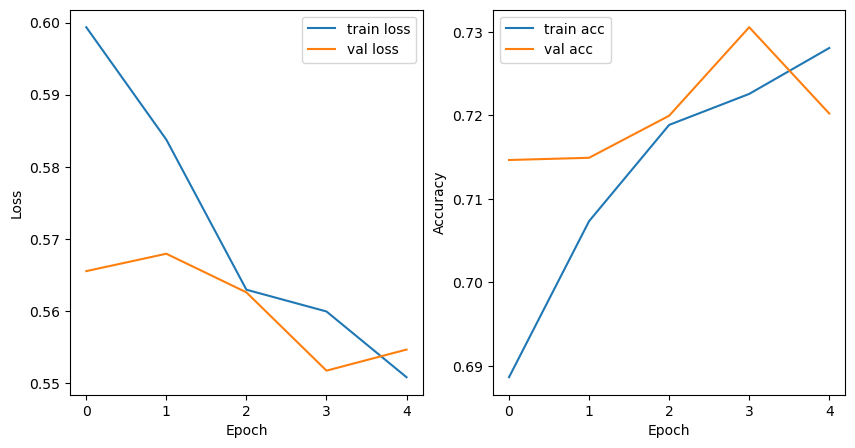

In [38]:
# plot the history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history_byol, label='train loss')
plt.plot(val_loss_history_byol, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc_history_byol, label='train acc')
plt.plot(val_acc_history_byol, label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

